In [2]:
import pandas as pd
import numpy as np
from scipy import stats
from pandas.api import types as ptypes
from scipy.stats import shapiro, mannwhitneyu, chi2_contingency

In [4]:
from scipy.stats import fisher_exact
import statsmodels.formula.api as smf

In [5]:
from numpy.linalg import LinAlgError

In [7]:
import matplotlib.pyplot as plt

In [31]:
def summarize_and_test(df, group_col, alpha=0.05):
    # 1) build lists of columns, excluding the group_col
    numeric_cols = [
        col for col in df.select_dtypes(include=[np.number]).columns
        if col != group_col
    ]
    cat_cols = [
        col for col in df.select_dtypes(include=['category','object','bool']).columns
        if col != group_col
    ]

    groups = df[group_col].dropna().unique()
    results = []

    # 2) Numeric: mean(sd) + test
    for col in numeric_cols:
        summary = {}
        # per‐group descriptives
        desc = df.groupby(group_col)[col].agg(['mean','std','count']).to_dict()
        # normality per group (only if 3 ≤ n ≤ 5000)
        p_norm = {
            g: (shapiro(df.loc[df[group_col]==g, col])[1]
                if 3 <= len(df[df[group_col]==g]) <= 5000 else 1.0)
            for g in groups
        }
        test_name, p_val = (
            ('Mann-Whitney U', mannwhitneyu(
                df[df[group_col]==groups[0]][col],
                df[df[group_col]==groups[1]][col],
                alternative='two-sided'
            ).pvalue)
            if any(p < alpha for p in p_norm.values())  # non‐normal → MWU
            else ('t-test',
                  # you could import and run a t-test here
                  np.nan)
        )
        results.append({
            'variable': col,
            'test': test_name,
            'p_value': p_val,
            **{f"{g}_mean(sd)": f"{desc['mean'][g]:.2f} ({desc['std'][g]:.2f})"
               for g in groups}
        })

    # 3) Categorical: total(%) + chi-square/​Fisher
    for col in cat_cols:
        ct = pd.crosstab(df[col], df[group_col])
        chi2, p_val, _, _ = chi2_contingency(ct)
        for level in ct.index:
            results.append({
                'variable': col,
                'category': level,
                'test': 'Chi-square',
                'p_value': p_val,
                'counts': '; '.join(
                    f"{g}: {ct.loc[level, g]} ({ct.loc[level, g]/ct.sum(axis=0)[g]*100:.1f}%)"
                    for g in groups
                )
            })

    return pd.DataFrame(results)


In [42]:
filename = 'data_basal_musculoesqueleticos.csv'
folder = 'Data'
df_test = pd.read_csv(f"{folder}/{filename}", encoding='latin-1')
# Nueva variable dependiente combinada solucion a parte 5
df_test['Diagnostico_Musculo_bin'] = np.where(
    (df_test['Musculoesqueleticos'] == 1) | (df_test['Diagnostico'] != 'Ninguno'),
    1, 0)
#df_test['Diagnostico_bin'] = np.where(df_test['Diagnostico'] != 'Ninguno', 1, 0)
#R: Diagnostico_bin = Musculoesqueleticos or Diagnostico_bin
#df_test = df_test.drop(columns=['Diagnostico'])
#summary_table = summarize_and_test(df_test, group_col='Diagnostico_bin')
summary_table = summarize_and_test(df_test, group_col='Diagnostico_Musculo_bin')

/home/joel/Rut/BioEst-Final-Project/.env/lib/python3.13/site-packages/scipy/stats/_axis_nan_policy.py:586: UserWarning: scipy.stats.shapiro: Input data has range zero. The results may not be accurate.
  res = hypotest_fun_out(*samples, **kwds)
/home/joel/Rut/BioEst-Final-Project/.env/lib/python3.13/site-packages/scipy/stats/_axis_nan_policy.py:586: UserWarning: scipy.stats.shapiro: Input data has range zero. The results may not be accurate.
  res = hypotest_fun_out(*samples, **kwds)


In [40]:
summary_table

,variable,test,p_value,0_mean(sd),1_mean(sd),category,counts
0,Edad,Mann-Whitney U,6.771357e-11,48.34 (18.17),62.49 (12.35),NaN,NaN
1,Estudios,Mann-Whitney U,1.860665e-09,6.34 (4.30),2.94 (3.33),NaN,NaN
2,HijosCuantos,Mann-Whitney U,3.330751e-04,3.36 (2.52),4.63 (2.81),NaN,NaN
3,PersonasViven,Mann-Whitney U,2.256137e-02,3.91 (2.01),3.35 (1.61),NaN,NaN
4,NumeroCuartos,Mann-Whitney U,5.071305e-01,1.98 (0.93),2.07 (1.00),NaN,NaN
...,...,...,...,...,...,...,...
190,AnsiedadDepresionId,Chi-square,2.534973e-01,NaN,NaN,Regular,0: 53 (11.9%); 1: 13 (19.1%)
191,EstadoSaludId,Chi-square,1.064040e-05,NaN,NaN,Bueno,0: 258 (58.0%); 1: 25 (36.8%)
192,EstadoSaludId,Chi-square,1.064040e-05,NaN,NaN,Malo,0: 4 (0.9%); 1: 0 (0.0%)
193,EstadoSaludId,Chi-square,1.064040e-05,NaN,NaN,Muy bueno,0: 73 (16.4%); 1: 6 (8.8%)


In [34]:
alpha = 0.05
sig_vars = summary_table.loc[summary_table['p_value'] < alpha, 'variable'].unique()

binary_cats = []
others = []

for var in sig_vars:
    levels = df_test[var].nunique()
    if levels == 2:
        binary_cats.append(var)
    else:
        others.append(var)

or_cat = []

for var in binary_cats:
    #ct = pd.crosstab(df_test[var], df_test['Diagnostico_bin'])
    ct = pd.crosstab(df_test[var], df_test['Diagnostico_Musculo_bin'])
    OR, P_val = fisher_exact(ct.values)
    or_cat.append({
        'variable': var,
        'level': 'N/A',
        'method': 'Fisher',
        'oods_ratio': OR,
        'ci_lower': np.nan,
        'ci_upper': np.nan,
        'p_value': P_val,
    })

or_lr = []
for var in others:
    if pd.api.types.is_numeric_dtype(df_test[var]):
        formula = f"Diagnostico_Musculo_bin ~ {var}"
    else:
        formula = f"Diagnostico_Musculo_bin ~ C({var})"
    try:
        model = smf.logit(formula, data=df_test).fit(disp=0)
    except (LinAlgError, ValueError) as e:
        #R: save the variable name and error message
        print(f"Error occurred while fitting model for variable: {var}, Error: {e}")
        continue

    ci_df = model.conf_int()

    for param, coef in model.params.items():
        if param == 'Intercept':
            continue
        level = param if param.startswith(f"C({var})") else var

        or_lr.append({
            'variable': var,
            'level': level,
            'method': 'Logistic regression',
            'oods_ratio': np.exp(coef),
            'ci_lower': np.exp(ci_df.loc[param,0]),
            'ci_upper': np.exp(ci_df.loc[param,1]),
            'p_value': model.pvalues[param],
        })

or_results = pd.DataFrame(or_cat + or_lr)
print(or_results)

Error occurred while fitting model for variable: ElectricidadId, Error: Singular matrix
                            variable                                    level  \
0                  vivienda_tienen_3                                      N/A   
1                  vivienda_tienen_9                                      N/A   
2                     Comorbilidad_2                                      N/A   
3                     Comorbilidad_6                                      N/A   
4                    Comorbilidad_14                                      N/A   
5                    HablasEspanolId                                      N/A   
6                  EscribesEspanolId                                      N/A   
7                     ReumaFamiliaId                                      N/A   
8             TenidoDolorSieteDiasId                                      N/A   
9            TenidoDolorHistoiricoId                                      N/A   
10                Med

/home/joel/Rut/BioEst-Final-Project/.env/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/tmp/ipykernel_48348/39700391.py:56: RuntimeWarning: overflow encountered in exp
  'ci_upper': np.exp(ci_df.loc[param,1]),
/tmp/ipykernel_48348/39700391.py:56: RuntimeWarning: overflow encountered in exp
  'ci_upper': np.exp(ci_df.loc[param,1]),
/home/joel/Rut/BioEst-Final-Project/.env/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/tmp/ipykernel_48348/39700391.py:56: RuntimeWarning: overflow encountered in exp
  'ci_upper': np.exp(ci_df.loc[param,1]),
/tmp/ipykernel_48348/39700391.py:56: RuntimeWarning: overflow encountered in exp
  'ci_upper': np.exp(ci_df.loc[param,1]),
/hom

In [35]:
sig_vars

array(['Edad', 'Estudios', 'HijosCuantos', 'PersonasViven', 'Presion_Sys',
       'GlucosaValor', 'HorasTrabajas', 'DolorSieteDias_ocaciones',
       'DolorHistoirico_ocaciones', 'Enfermedades_numero_medicamentos',
       'Enfermedades_costo_medicamentos', 'DejaHacer', 'HAQval',
       'Eurocol', 'vivienda_tienen_3', 'vivienda_tienen_9',
       'Comorbilidad_2', 'Comorbilidad_6', 'Comorbilidad_14',
       'DolorSieteDias_mediananivel', 'DolorHistoirico_mediananivel',
       'Musculoesqueleticos', 'HablasEspanolId', 'EscribesEspanolId',
       'ParedesId', 'ElectricidadId', 'ReumaFamiliaId',
       'TenidoDolorSieteDiasId', 'TenidoDolorHistoiricoId',
       'MedicamentoDolorId', 'HAQvalbin', 'TipoTransporte', 'MovilidadId',
       'CuidadoPersonalId', 'ActividadesDiariasId',
       'DolorCalidaddeVidaId', 'EstadoSaludId'], dtype=object)

In [ ]:
drop_vars = ['ElectricidadId', 'Musculoesqueleticos', 'EstadoSaludId'] #eliminando columnas que se que estan mal

kept_vars = [var for var in sig_vars if var not in drop_vars]

kept_vars = ['TenidoDolorHistoiricoId', 'HAQval','Edad', 'Comorbilidad_14']#eliminando todas menos las que mostraron mejor relacion

In [120]:
predictors = []
for var in kept_vars:
    if pd.api.types.is_numeric_dtype(df_test[var]):
        predictors.append(var)
    else:
        predictors.append(f"C({var})")

formula = "Diagnostico_Musculo_bin ~ " + " + ".join(predictors)
print("Fitting model with formula:",formula)

multi_model = smf.logit(formula, data=df_test).fit(
    method='bfgs',
    maxiter=200,
    epsilon=1e-8,
    disp=False
)
#print(multi_model.mle_retvals)

#3. Pseudo-R2Cambiar la combinación de variables independientes para encontrar el mejor OR
n = int(multi_model.nobs)
llf = multi_model.llf
llnull = multi_model.llnull

# McFadden's R2
mcfadden_r2 = multi_model.prsquared
# Cox & Snell's R2
cox_snell_r2 = 1 - np.exp((llnull - llf)*2/n)
# Nagelkerke's R2
nagelkerke_r2 = cox_snell_r2 / (1 - np.exp(2 * llnull/ n))

print(f"McFadden's R2: {mcfadden_r2:.4f}")
print(f"Cox & Snell's R2: {cox_snell_r2:.4f}")
print(f"Nagelkerke's R2: {nagelkerke_r2:.4f}")

params = multi_model.params.drop('Intercept')
conf = multi_model.conf_int().loc[params.index]
pvals = multi_model.pvalues.loc[params.index]

rows = []

for param, coef in params.items():
    if param.startswith('C('):
        var, level = param.split('[')
        var = var[2:-1]
        level = level.rstrip(']')
        level = level.replace('T.', '')
    else:
        var = param
        level = 'per unit'

    rows.append({
        'variable': var,
        'level': level,
        'method': 'Multivariable Logistic regression',
        'odds_ratio': np.exp(coef),
        'ci_lower': np.exp(conf.loc[param, 0]),
        'ci_upper': np.exp(conf.loc[param, 1]),
        'p_value': pvals[param],
    })
multi_results = pd.DataFrame(rows)

print(multi_results)


Fitting model with formula: Diagnostico_Musculo_bin ~ C(TenidoDolorHistoiricoId) + HAQval + C(ReumaFamiliaId) + Edad + Comorbilidad_14
McFadden's R2: 0.2626
Cox & Snell's R2: 0.1857
Nagelkerke's R2: 0.3423
                  variable     level                             method  \
0  TenidoDolorHistoiricoId       SÃ­  Multivariable Logistic regression   
1           ReumaFamiliaId       SÃ­  Multivariable Logistic regression   
2                   HAQval  per unit  Multivariable Logistic regression   
3                     Edad  per unit  Multivariable Logistic regression   
4          Comorbilidad_14  per unit  Multivariable Logistic regression   

   odds_ratio  ci_lower   ci_upper       p_value  
0    3.163279  1.699345   5.888347  2.806885e-04  
1    1.566789  0.761140   3.225199  2.228426e-01  
2    2.137989  1.358017   3.365932  1.032288e-03  
3    1.033496  1.015133   1.052191  3.157040e-04  
4   10.872390  4.261190  27.740807  5.942062e-07  


R2 originales con todas las significativas
Fitting model with formula:

Diagnostico_bin ~ Edad + Estudios + HijosCuantos + PersonasViven + Presion_Sys + GlucosaValor + HorasTrabajas + DolorSieteDias_ocaciones + DolorHistoirico_ocaciones + Enfermedades_numero_medicamentos + Enfermedades_costo_medicamentos + DejaHacer + HAQval + Eurocol + vivienda_tienen_3 + vivienda_tienen_9 + Comorbilidad_2 + Comorbilidad_6 + Comorbilidad_14 + DolorSieteDias_mediananivel + DolorHistoirico_mediananivel + C(Musculoesqueleticos) + C(HablasEspanolId) + C(EscribesEspanolId) + C(ParedesId) + C(ElectricidadId) + C(ReumaFamiliaId) + C(TenidoDolorSieteDiasId) + C(TenidoDolorHistoiricoId) + C(MedicamentoDolorId) + C(HAQvalbin) + C(TipoTransporte) + C(MovilidadId) + C(CuidadoPersonalId) + C(ActividadesDiariasId) + C(DolorCalidaddeVidaId) + C(EstadoSaludId)

McFadden's R2: 0.4652
Cox & Snell's R2: 0.3051
Nagelkerke's R2: 0.5622


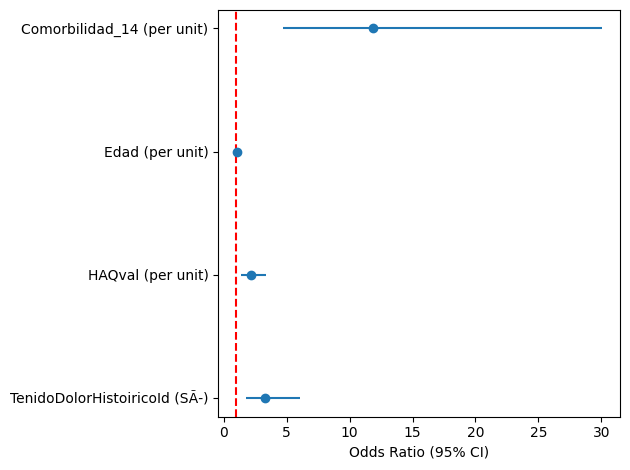

In [114]:
ORs = multi_results['odds_ratio']
ci_lowers = multi_results['ci_lower']
ci_uppers = multi_results['ci_upper']

errors = [ORs - ci_lowers, ci_uppers - ORs]

fig, ax = plt.subplots()

ax.errorbar(ORs,
            range(len(ORs)),
            xerr=errors,
            fmt='o')

ax.set_yticks(range(len(ORs)))
ax.set_yticklabels(
    multi_results['variable'] + ' (' + multi_results['level'] + ')'
)

ax.axvline(x=1, color='red', linestyle='--')

ax.set_xlabel('Odds Ratio (95% CI)')
plt.tight_layout()
plt.show()

In [50]:
# Visualizar los cambios en una tabla (filas 15 a 40)
tabla_cambios = df_test[['Diagnostico', 'Musculoesqueleticos', 'Diagnostico_Musculo_bin']].copy()
print(tabla_cambios.iloc[15:41])

   Diagnostico Musculoesqueleticos  Diagnostico_Musculo_bin
15     Ninguno             Ninguno                        0
16     Ninguno             Ninguno                        0
17          OA                 SDR                        1
18     Ninguno             Ninguno                        0
19     Ninguno             Ninguno                        0
20     Ninguno             Ninguno                        0
21     Ninguno             Ninguno                        0
22          OA             Ninguno                        1
23     Ninguno             Ninguno                        0
24     Ninguno             Ninguno                        0
25     Ninguno                 SDR                        0
26     Ninguno             Ninguno                        0
27     Ninguno             Ninguno                        0
28     Ninguno             Ninguno                        0
29     Ninguno             Ninguno                        0
30     Ninguno                 SDR      